<a href="https://colab.research.google.com/github/ujjalkumarmaity/Twitter_Sentiment_Analysis/blob/master/Twitter_Sentiment_Analysis_naive_bayes_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

__What is Sentiment Analysis?__

Sentiment analysis is a process of identifying an attitude of the author on a topic that is being written about. 

#### Table of contents

1. Load the libraries
1. Load Dataset
1. EDA
1. Preprocessing Tweet Text
1. Featurization
    1. Bag-of-Words
    1. TF-IDF
    1. Word2vec
1. Resample
    1. Upsampling BOW
    2. Upsampling TF-IDF
    1. Upsampling word2vec
1. Split Dataset
1. Model Selection
    1. naive bayes  
1. Summary


# Load the libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem import PorterStemmer,WordNetLemmatizer
from wordcloud import WordCloud
import re
import gensim
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.utils import resample
from sklearn.metrics import accuracy_score,f1_score

# Load Dataset

In [4]:
df=pd.read_csv('/content/drive/My Drive/Colab Notebooks/Twitter/train.csv.zip')
test=pd.read_csv('/content/drive/My Drive/Colab Notebooks/Twitter/test.csv.zip')
df.head(4)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...


#  EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [6]:
print('shape of train dataset',df.shape)
df.label.value_counts()

shape of train dataset (31962, 3)


0    29720
1     2242
Name: label, dtype: int64

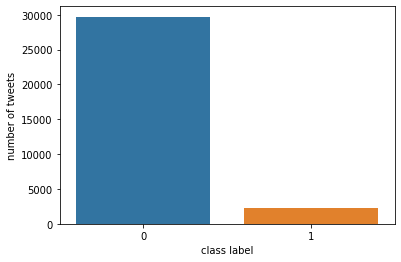

In [7]:
# 
sns.countplot(df.label,)
plt.xlabel('class label')
plt.ylabel('number of tweets')
plt.show()

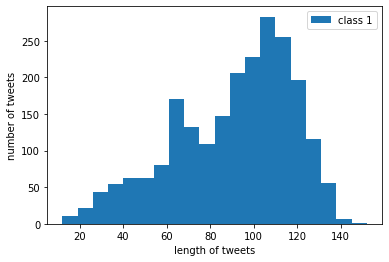

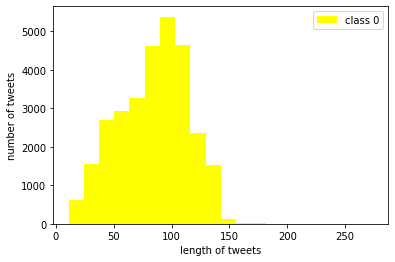

In [8]:
plt.hist(df[df['label']==1].tweet.str.len(),bins=20,label='class 1')
plt.legend()
plt.xlabel('length of tweets')
plt.ylabel('number of tweets')
plt.show()
plt.hist(df[df['label']==0].tweet.str.len(),color='yellow',bins=20,label='class 0')
plt.legend()
plt.xlabel('length of tweets')
plt.ylabel('number of tweets')
plt.show()

#   Preprocessing Tweet Text

1. Removing Twitter Handles (@user)
2. Removing urls from text 
3. Removing Punctuations, Numbers, and Special Characters

5. Convert the word to lowercase
6. Remove Stopwords
7. Stemming the word
8. Lemmatization<br>

After which we collect the words used to describe positive and negative reviews

In [9]:
text=df['tweet'].values.tolist()
text_test=test['tweet'].values.tolist()
text+=text_test
print(len(text))

49159


In [12]:
import nltk
stopword=nltk.corpus.stopwords.words('english')
stopword.remove('not')
for index,text_ in enumerate(text):
    text_=re.sub(r'@[\w]*','',text_) #Removing Twitter Handles (@user)
    text_=re.sub(r'http/S+','',text_) #Removing urls from text 
    text_=re.sub(r'[^A-Za-z#]',' ',text_) #Removing Punctuations, Numbers, and Special Characters
    text_=" ".join(i.lower() for i in text_.split() if i.lower() not in stopword) #Removing stopword
    text[index]=text_

In [15]:
#Stemming the word
pt=PorterStemmer()
wordnet=WordNetLemmatizer()
for index,text_ in enumerate(text):
    text_=" ".join(pt.stem(i) for i in text_.split())
    text_=" ".join(wordnet.lemmatize(i) for i in text_.split())  
    text[index]=text_


In [16]:
df['preprocess_tweet']=text[:len(df)]
df['length_tweet']=df['preprocess_tweet'].str.len()
test['preprocess_tweet']=text[len(df):]
df.head()

,id,label,tweet,preprocess_tweet,length_tweet
0,1,0,@user when a father is dysfunctional and is s...,father dysfunct selfish drag kid dysfunct #run,46
1,2,0,@user @user thanks for #lyft credit i can't us...,thank #lyft credit use caus offer wheelchair v...,73
2,3,0,bihday your majesty,bihday majesti,14
3,4,0,#model i love u take with u all the time in ...,#model love u take u time ur,28
4,5,0,factsguide: society now #motivation,factsguid societi #motiv,24


# Featurization

###BOW

In [17]:
train=df.copy()
train.drop(columns=['id','tweet','preprocess_tweet'],inplace=True)


In [18]:
bow=CountVectorizer( min_df=2, max_features=1000)
bow.fit(df['preprocess_tweet'])
bow_df=bow.transform(df['preprocess_tweet']).toarray()
print('feature name==',bow.get_feature_names()[:10])
print('number of uniqe words',bow_df.shape[1])
print('shape',bow_df.shape)
bow_train=pd.DataFrame(bow_df)
bow_train['length_tweet']=df['length_tweet']
bow_train['label']=df['label']
bow_train.head()

feature name== ['abl', 'absolut', 'accept', 'account', 'act', 'action', 'actor', 'actual', 'ad', 'adapt']
number of uniqe words 1000
shape (31962, 1000)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,length_tweet,label
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,46,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,73,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,0


### TF-IDF Features (Bi-Grams)

In [19]:
tfidf=TfidfVectorizer(ngram_range=(1, 2),min_df=2,max_features=1000)
tfidf.fit(df['preprocess_tweet'])
tfidf_df=tfidf.transform(df['preprocess_tweet']).toarray()
print('number of uniqe words',bow_df.shape[1])
print('shape',tfidf_df.shape)
tfidf_train=pd.DataFrame(tfidf_df)
tfidf_train['length_tweet']=df['length_tweet']
tfidf_train['label']=df['label']
tfidf_train.head()

number of uniqe words 1000
shape (31962, 1000)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,length_tweet,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24,0


###Word2vec
__size:__ The number of dimensions of the embeddings and the default is 100.

__window:__ The maximum distance between a target word and words around the target word. The default window is 5.

__min_count:__ The minimum count of words to consider when training the model; words with occurrence less than this count will be ignored. The default for min_count is 5.

__workers:__ The number of partitions during training and the default workers is 3.

__sg:__ The training algorithm, either CBOW(0) or skip gram(1). The default training algorithm is CBOW.

In [20]:
tokenize=df['preprocess_tweet'].apply(lambda x: x.split())
w2vec_model=gensim.models.Word2Vec(tokenize,min_count = 1, size = 100, window = 5, sg = 1)
w2vec_model.train(tokenize,total_examples= len(df['preprocess_tweet']),epochs=20)

(4814805, 5011220)

In [21]:
w2vec_model.most_similar('father')

[('#fathersday', 0.7955729961395264),
 ('dad', 0.7825347781181335),
 ('#father', 0.755081295967102),
 ('fathersday', 0.732908308506012),
 ('papa', 0.713297426700592),
 ('#dad', 0.7117035388946533),
 ('#daddi', 0.7028311491012573),
 ('#clapton', 0.6992714405059814),
 ('day#', 0.6938574314117432),
 ('#hackney', 0.6931199431419373)]

In [22]:
w2v_words = list(w2vec_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  36842
sample words  ['father', 'dysfunct', 'selfish', 'drag', 'kid', '#run', 'thank', '#lyft', 'credit', 'use', 'caus', 'offer', 'wheelchair', 'van', 'pdx', '#disapoint', '#getthank', 'bihday', 'majesti', '#model', 'love', 'u', 'take', 'time', 'ur', 'factsguid', 'societi', '#motiv', 'huge', 'fan', 'fare', 'big', 'talk', 'leav', 'chao', 'pay', 'disput', 'get', '#allshowandnogo', 'camp', 'tomorrow', 'danni', 'next', 'school', 'year', 'exam', 'think', '#school', '#exam', '#hate']


In [23]:
vector=[]
from tqdm import tqdm
for sent in tqdm(tokenize):
  sent_vec=np.zeros(100)
  count =0
  for word in sent: 
    if word in w2v_words:
      vec = w2vec_model.wv[word]
      sent_vec += vec 
      count += 1
  if count != 0:
    sent_vec /= count #normalize
  vector.append(sent_vec)
print(len(vector))
print(len(vector[0]))        

100%|██████████| 31962/31962 [00:27<00:00, 1171.18it/s]

31962
100


In [24]:
#example
l='father dysfunct selfish drag kid dysfunct'
count=0
vcc=np.zeros(100)
for word in l:
  if word in w2v_words:
    v=w2vec_model.wv[word]
    vcc+=v
    count+=1
vcc

array([-14.01306087,   1.68960865,  -9.6688134 ,  -0.79945426,
        -4.32031102,   1.13948869,  -9.15959865,  -1.53612507,
        12.85300905,  -2.50109439, -21.55385613,  -1.46691304,
        10.29535834,   1.18136305,   1.07094801,  -6.16914511,
        12.82774605,  -0.36617972,   9.11416884,  11.40495959,
        12.17745749,   8.51934207,  11.37620583,  -0.05332977,
        10.01333436,  -7.59717691,  -2.60241546, -18.08020302,
        12.62411554,  -2.09437254,   3.87509414,  -0.30185577,
         0.25782927,  -4.01626634,  -7.72648367,   4.53105583,
       -21.18498206,   1.34226128,  -2.68843705,   7.10924396,
         5.60346666,   0.36707982,   2.97465551,   9.52108746,
        13.15729664,  -1.01519357,  -1.49408339,  -2.0938724 ,
        -2.86806445,  -1.95933458,   8.97184869,  -1.87315788,
        -0.38660387,   4.57955649,  15.18131525,   0.9001895 ,
         1.73643552,  11.0177561 ,  -2.08726924,   8.85219911,
       -13.69311786, -11.13942399,  -5.11790008, -11.37

In [25]:

print('number of uniqe words',len(vector[1]))
w2v_train=pd.DataFrame(vector)
w2v_train['length_tweet']=df['length_tweet']
w2v_train['label']=df['label']
w2v_train.head()

number of uniqe words 100


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,length_tweet,label
0,-0.147460,-0.097678,0.088494,0.004374,-0.062964,-0.328329,-0.714397,0.341717,0.382869,0.147038,-0.464474,0.053450,0.416182,-0.196511,0.224757,-0.447903,0.020688,0.052147,0.170770,0.312297,0.295900,-0.068509,0.017155,0.219935,-0.188711,-0.363942,0.267753,-0.569244,0.168464,-0.326034,-0.035214,-0.394221,-0.415872,-0.075913,0.135408,0.487998,-0.178082,0.422432,0.084338,0.035743,...,-0.188469,-0.184428,0.392246,0.051109,0.407122,-0.072494,-0.143106,0.201330,0.329444,-0.072331,0.233861,-0.217848,0.040891,-0.555924,0.525830,0.131002,-0.164339,0.155274,0.184851,-0.278382,-0.145997,0.081749,0.271423,0.497058,-0.099270,0.231156,0.489525,0.271597,0.027496,0.304206,0.137247,0.248933,-0.236852,-0.097226,0.203395,0.354118,-0.227735,-0.266756,46,0
1,-0.248506,-0.237401,-0.118447,0.002282,-0.264117,-0.213466,-0.442112,0.157877,0.424557,0.020851,-0.424815,-0.051164,0.290629,-0.017809,0.203737,-0.201438,0.104577,-0.147462,0.077319,0.081846,0.451093,0.046522,0.320480,0.100871,0.145660,-0.381138,0.050285,-0.131739,0.032771,-0.264354,-0.045050,0.045629,-0.301480,-0.042048,-0.215937,0.565174,-0.068848,-0.043755,-0.070155,-0.025475,...,-0.184743,-0.160854,0.179417,0.021772,0.112670,-0.117877,-0.126190,0.222059,0.071635,0.036887,-0.033188,0.138262,-0.242840,-0.296606,0.313950,0.110616,0.006270,-0.030620,0.229740,0.135082,-0.249679,0.285744,0.193301,0.293858,-0.049152,0.232706,0.078876,0.155021,0.080390,-0.040582,0.042223,0.068798,0.058298,-0.073628,0.061461,0.391433,-0.113151,-0.126570,73,0
2,-0.179936,0.293784,-0.212988,-0.322106,0.352358,0.024212,-0.557215,-0.213535,0.119070,0.014492,-0.507802,0.034378,0.271758,-0.680013,-0.747964,-0.851890,-0.041808,-0.083609,0.284290,0.252335,0.623315,-0.100416,0.680147,-0.380822,-0.188857,-0.839965,0.043943,-0.361800,-0.270911,-0.193946,-0.210341,0.504183,0.361796,0.240540,0.362023,-0.192814,0.585600,-0.166112,-0.304271,1.032141,...,-0.061471,-0.030722,0.370069,-0.192609,0.443559,-0.179047,-0.216688,0.242608,0.487453,-0.318522,-0.340943,0.689147,-0.464785,0.032341,0.044956,1.120929,-0.545029,0.571596,-0.295578,-0.508754,-0.460345,0.354108,-0.134406,-0.282871,0.135864,0.869222,0.151060,0.804975,-0.432120,0.095488,-0.141412,0.681106,-0.139110,-0.173834,0.360844,0.364628,-0.099067,-0.583648,14,0
3,-0.874540,-0.508389,-0.097178,-0.185592,-0.164945,-0.021888,0.148799,0.176633,1.118791,-0.067648,-1.160098,0.433234,0.976908,-0.074678,0.376586,-0.363000,0.346469,-0.017564,0.188840,0.291289,0.252449,0.070924,0.848680,0.100892,0.174273,-0.445899,-0.677855,-0.658154,0.231274,-0.198834,-0.070111,-0.065212,0.252321,-0.577186,-0.337920,0.283148,-0.169306,0.338651,0.291555,0.193079,...,0.227905,-0.234482,0.062300,0.061664,0.610008,-0.117541,-0.353934,0.086905,0.098282,-0.051869,-0.037448,0.031302,-0.065125,0.168145,0.581184,0.224364,-0.410974,1.092959,-0.287212,0.142931,-0.423685,0.344722,0.333003,0.612093,-0.408202,-0.372804,0.700861,-0.242516,0.131358,0.074990,0.571326,-0.112190,-0.145728,-0.167918,0.284699,0.922275,-0.131792,0.152953,28,0
4,-0.127830,0.472372,-0.385039,-0.989061,0.476613,-0.496550,-0.385541,0.469353,0.880657,-0.293986,-0.379886,0.338787,0.311469,-0.434966,0.009103,-0.497619,0.112856,-0.188123,-0.114664,-0.336460,0.389804,0.334340,0.139362,0.004538,-0.177729,-0.939102,-0.130015,-0.445822,0.505941,-0.537480,-0.216517,-0.368081,-0.087099,-0.067592,0.315930,0.274959,-0.648208,-0.009660,-0.200667,-0.002576,...,0.108726,0.041894,0.043285,0.101078,0.168881,-0.098179,0.104712,-0.158883,-0.013307,-0.137852,0.133818,0.254561,-0.188396,-0.745429,0.809807,0.384268,0.213787,-0.325210,0.359370,0.054180,-0.529181,0.408845,0.133737,1.053292,-0.248492,-0.347215,-0.216303,0.247768,0.019928,0.439301,-0.533154,0.054625,0.374660,-0.481842,0.087912,0.297434,-0.667158,-0.507274,24,0


#Resample

##Upsampling BOW

shape (59440, 1002)


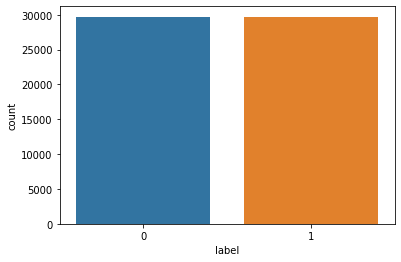

In [26]:
major_class_0,major_class_1=bow_train.label.value_counts()
df_major=bow_train[bow_train['label']==0]
df_minor=bow_train[bow_train['label']==1]
df_minor_upsampled = resample(df_minor, 
                                 replace=True,     # sample with replacement
                                 n_samples=major_class_0)
df_bow_upsampled = pd.concat([df_major, df_minor_upsampled])
print('shape',df_bow_upsampled.shape)
sns.countplot(df_bow_upsampled.label)

##Upsampling TF-IDF

shape (59440, 1002)


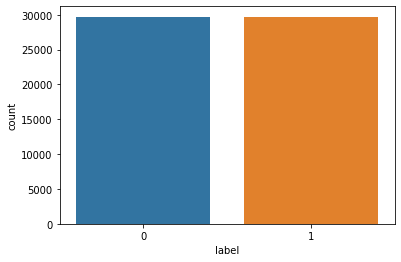

In [27]:
major_class_0,major_class_1=tfidf_train.label.value_counts()
df_major=tfidf_train[tfidf_train['label']==0]
df_minor=tfidf_train[tfidf_train['label']==1]
df_minor_upsampled = resample(df_minor, 
                                 replace=True,     # sample with replacement
                                 n_samples=major_class_0)
df_tfidf_upsampled = pd.concat([df_major, df_minor_upsampled])
print('shape',df_tfidf_upsampled.shape)
sns.countplot(df_tfidf_upsampled.label)

##Upsampling  word2vec

shape (59440, 102)


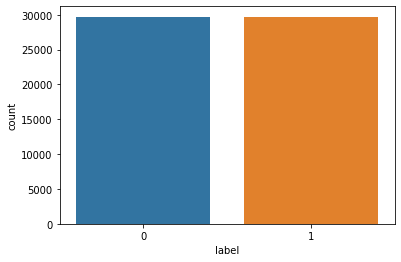

In [28]:
major_class_0,major_class_1=w2v_train.label.value_counts()
df_major=w2v_train[w2v_train['label']==0]
df_minor=w2v_train[w2v_train['label']==1]
df_minor_upsampled = resample(df_minor, 
                                 replace=True,     # sample with replacement
                                 n_samples=major_class_0)
df_w2v_upsampled = pd.concat([df_major, df_minor_upsampled])
print('shape',df_w2v_upsampled.shape)
sns.countplot(df_w2v_upsampled.label)

# Split Dataset

In [29]:
x=df_bow_upsampled.iloc[:,0:-1]
y=df_bow_upsampled['label']
x_train_bow,x_test_bow,y_train_bow,y_test_bow=train_test_split(x,y,test_size=0.2)

In [30]:
x=df_tfidf_upsampled.iloc[:,0:-1]
y=df_tfidf_upsampled['label']
x_train_tfidf,x_test_tfidf,y_train_tfidf,y_test_tfidf=train_test_split(x,y,test_size=0.2)

In [31]:
x=df_w2v_upsampled.iloc[:,0:-1]
y=df_w2v_upsampled['label']
x_train_w2v,x_test_w2v,y_train_w2v,y_test_w2v=train_test_split(x,y,test_size=0.2)

#Model Selection

In [32]:
def f1_score_(y_proba,y_test):
  proba = y_proba[:,1] >= 0.3
  proba = proba.astype(np.int) 
  return f1_score( proba,y_test)   


## Naive bayes 

In [34]:
#use Bow
from sklearn.naive_bayes import BernoulliNB

model=BernoulliNB()
model.fit(x_train_bow,y_train_bow)
y_pred=model.predict(x_test_bow)
acc=accuracy_score(y_pred,y_test_bow)
print('Accuracy Score',acc)
y_proba=model.predict_proba(x_test_bow)
f1_scor=f1_score_(y_proba,y_test_bow)
print('f1 score ',f1_scor)

Accuracy Score 0.8645693135935397
f1 score  0.8682122775937764


In [35]:
#use tfidf

model=BernoulliNB()
model.fit(x_train_tfidf,y_train_tfidf)
y_pred=model.predict(x_test_tfidf)
acc=accuracy_score(y_pred,y_test_tfidf)
print('Accuracy Score',acc)
y_proba=model.predict_proba(x_test_tfidf)
f1_scor=f1_score_(y_proba,y_test_tfidf)
print('f1 score ',f1_scor)

Accuracy Score 0.8496803499327052
f1 score  0.8526435907189045


In [36]:
#use word2vec
model=BernoulliNB()
model.fit(x_train_w2v,y_train_w2v)
y_pred=model.predict(x_test_w2v)
acc=accuracy_score(y_pred,y_test_w2v)
print('Accuracy Score',acc)
y_proba=model.predict_proba(x_test_w2v)
f1_scor=f1_score_(y_proba,y_test_w2v)
print('f1 score ',f1_scor)

Accuracy Score 0.8110699865410498
f1 score  0.8182540944506281


#Summary
<table>
<tr>
<td colspan=2>BOW</td>
<td colspan=2>TF-IDF</td>
<td colspan=2>WORD2VEC</td>
</tr>
<td>Accuray</td>
<td>f1_score</td>
<td>Accuray</td>
<td>f1_score</td>
<td>Accuray</td>
<td>f1_score</td>
</tr>

<td>0.8645693135935397</td>
<td>0.8682122775937764</td>
<td>0.8496803499327052</td>
<td>0.85264359071890451</td>
<td>0.8110699865410498</td>
<td>0.8182540944506281</td>
</tr>

</table>

